## Chicago Crime Analysis

This problem deals with crime reporting data from Chicago. Your task is to download data about Crime Reports from the Chicago Open Data Portal and analyze it to better understand what type of crimes get reported in what (type of) neighborhoods.

1. Download reported crime data from the Chicago open data portal for 2017 and 2018.

2. Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

__Import Modules__

In [1]:
import cenpy as c
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from dateutil.parser import parse
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
%matplotlib inline

__Data Preprocessing__

In [2]:
# Read the downloaded datasets and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])

# Drop all rows with NAs in Latitude and Longitude

crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [3]:
#Create a Geopandas dataframe using Lat. and Lon. from crime_df: crime_gdf
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry="Coordinates")
crime_gdf = crime_gdf[["Date", "Block", "Primary Type", "Community Area", "Year", "Coordinates"]]
crime_gdf.crs = {"init":"epsg:4326"}

Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

1. The number of crimes of each type:

In [4]:
type_cnt_df = crime_gdf.groupby(["Primary Type", "Year"]).size().to_frame("Count")
type_cnt_df["Total"] = type_cnt_df.groupby(level=0)["Count"].transform("sum")
type_cnt_df = type_cnt_df.sort_values(["Total", "Year"], ascending=False)

In [5]:
type_cnt_df

Count   Total
Primary Type                      Year               
THEFT                             2018  64024  127610
                                  2017  63586  127610
BATTERY                           2018  49720   98857
                                  2017  49137   98857
CRIMINAL DAMAGE                   2018  27700   56655
                                  2017  28955   56655
ASSAULT                           2018  20342   39594
                                  2017  19252   39594
DECEPTIVE PRACTICE                2018  17863   35631
                                  2017  17768   35631
OTHER OFFENSE                     2018  16970   33935
                                  2017  16965   33935
BURGLARY                          2018  11687   24634
                                  2017  12947   24634
NARCOTICS                         2018  12798   24273
                                  2017  11475   24273
ROBBERY                           2018   9680   21549
                                  2017  11869   21549
MOTOR VEHICLE THEFT               2018   9964   21331
                                  2017  11367   21331
CRIMINAL TRESPASS                 2018   6881   13680
                                  2017   6799   13680
WEAPONS VIOLATION                 2018   5444   10126
                                  2017   4682   10126
OFFENSE INVOLVING CHILDREN        2018   2176    4321
                                  2017   2145    4321
CRIM SEXUAL ASSAULT               2018   1589    3130
                                  2017   1541    3130
PUBLIC PEACE VIOLATION            2018   1362    2858
                                  2017   1496    2858
...                                       ...     ...
PROSTITUTION                      2018    717    1451
                                  2017    734    1451
HOMICIDE                          2018    586    1262
                                  2017    676    1262
ARSON                             2018    372     816
                                  2017    444     816
LIQUOR LAW VIOLATION              2018    265     456
                                  2017    191     456
GAMBLING                          2018    201     392
                                  2017    191     392
STALKING                          2018    201     385
                                  2017    184     385
KIDNAPPING                        2018    169     359
                                  2017    190     359
INTIMIDATION                      2018    166     316
                                  2017    150     316
CONCEALED CARRY LICENSE VIOLATION 2018    148     217
                                  2017     69     217
OBSCENITY                         2018     86     166
                                  2017     80     166
NON-CRIMINAL                      2018     37      74
                                  2017     37      74
PUBLIC INDECENCY                  2018     14      24
                                  2017     10      24
HUMAN TRAFFICKING                 2018     14      22
                                  2017      8      22
OTHER NARCOTIC VIOLATION          2018      1      12
                                  2017     11      12
NON-CRIMINAL (SUBJECT SPECIFIED)  2018      3       5
                                  2017      2       5

[64 rows x 2 columns]

Text(0, 0.5, 'Frequency')

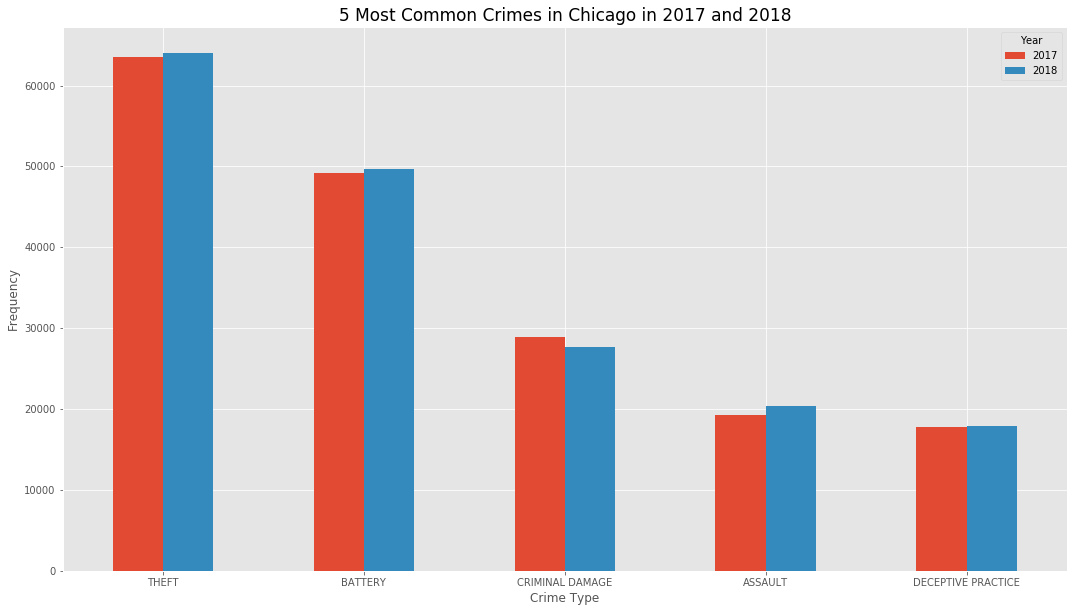

In [6]:
# 5 Most Common Crimes in Chicago

type_cnt_df[:10].Count.unstack().plot.bar(stacked=False, figsize=(18,10), rot=0)
plt.title("5 Most Common Crimes in Chicago in 2017 and 2018", fontsize=17)
plt.xlabel("Crime Type")
plt.ylabel("Frequency")

2. How these crimes change over time:

In [7]:
year_df = crime_df.groupby(["Year"]).size().to_frame("Count")
year_df

,Count
Year,
2017,264983
2018,263546


Text(0, 0.5, 'Frequency')

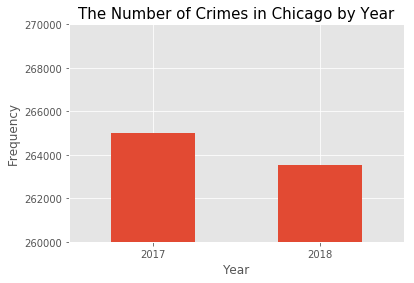

In [8]:
year_df.plot(kind="bar", legend=False, rot=0, ylim=(260000, 270000))
plt.title("The Number of Crimes in Chicago by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Frequency")

3. How these crimes are different by neighborhood:

In [9]:
neighbor_df = pd.concat([crime_df, pd.get_dummies(crime_df["Primary Type"])], axis=1)
variable_list = ["Community Area"] + list(neighbor_df["Primary Type"].unique())

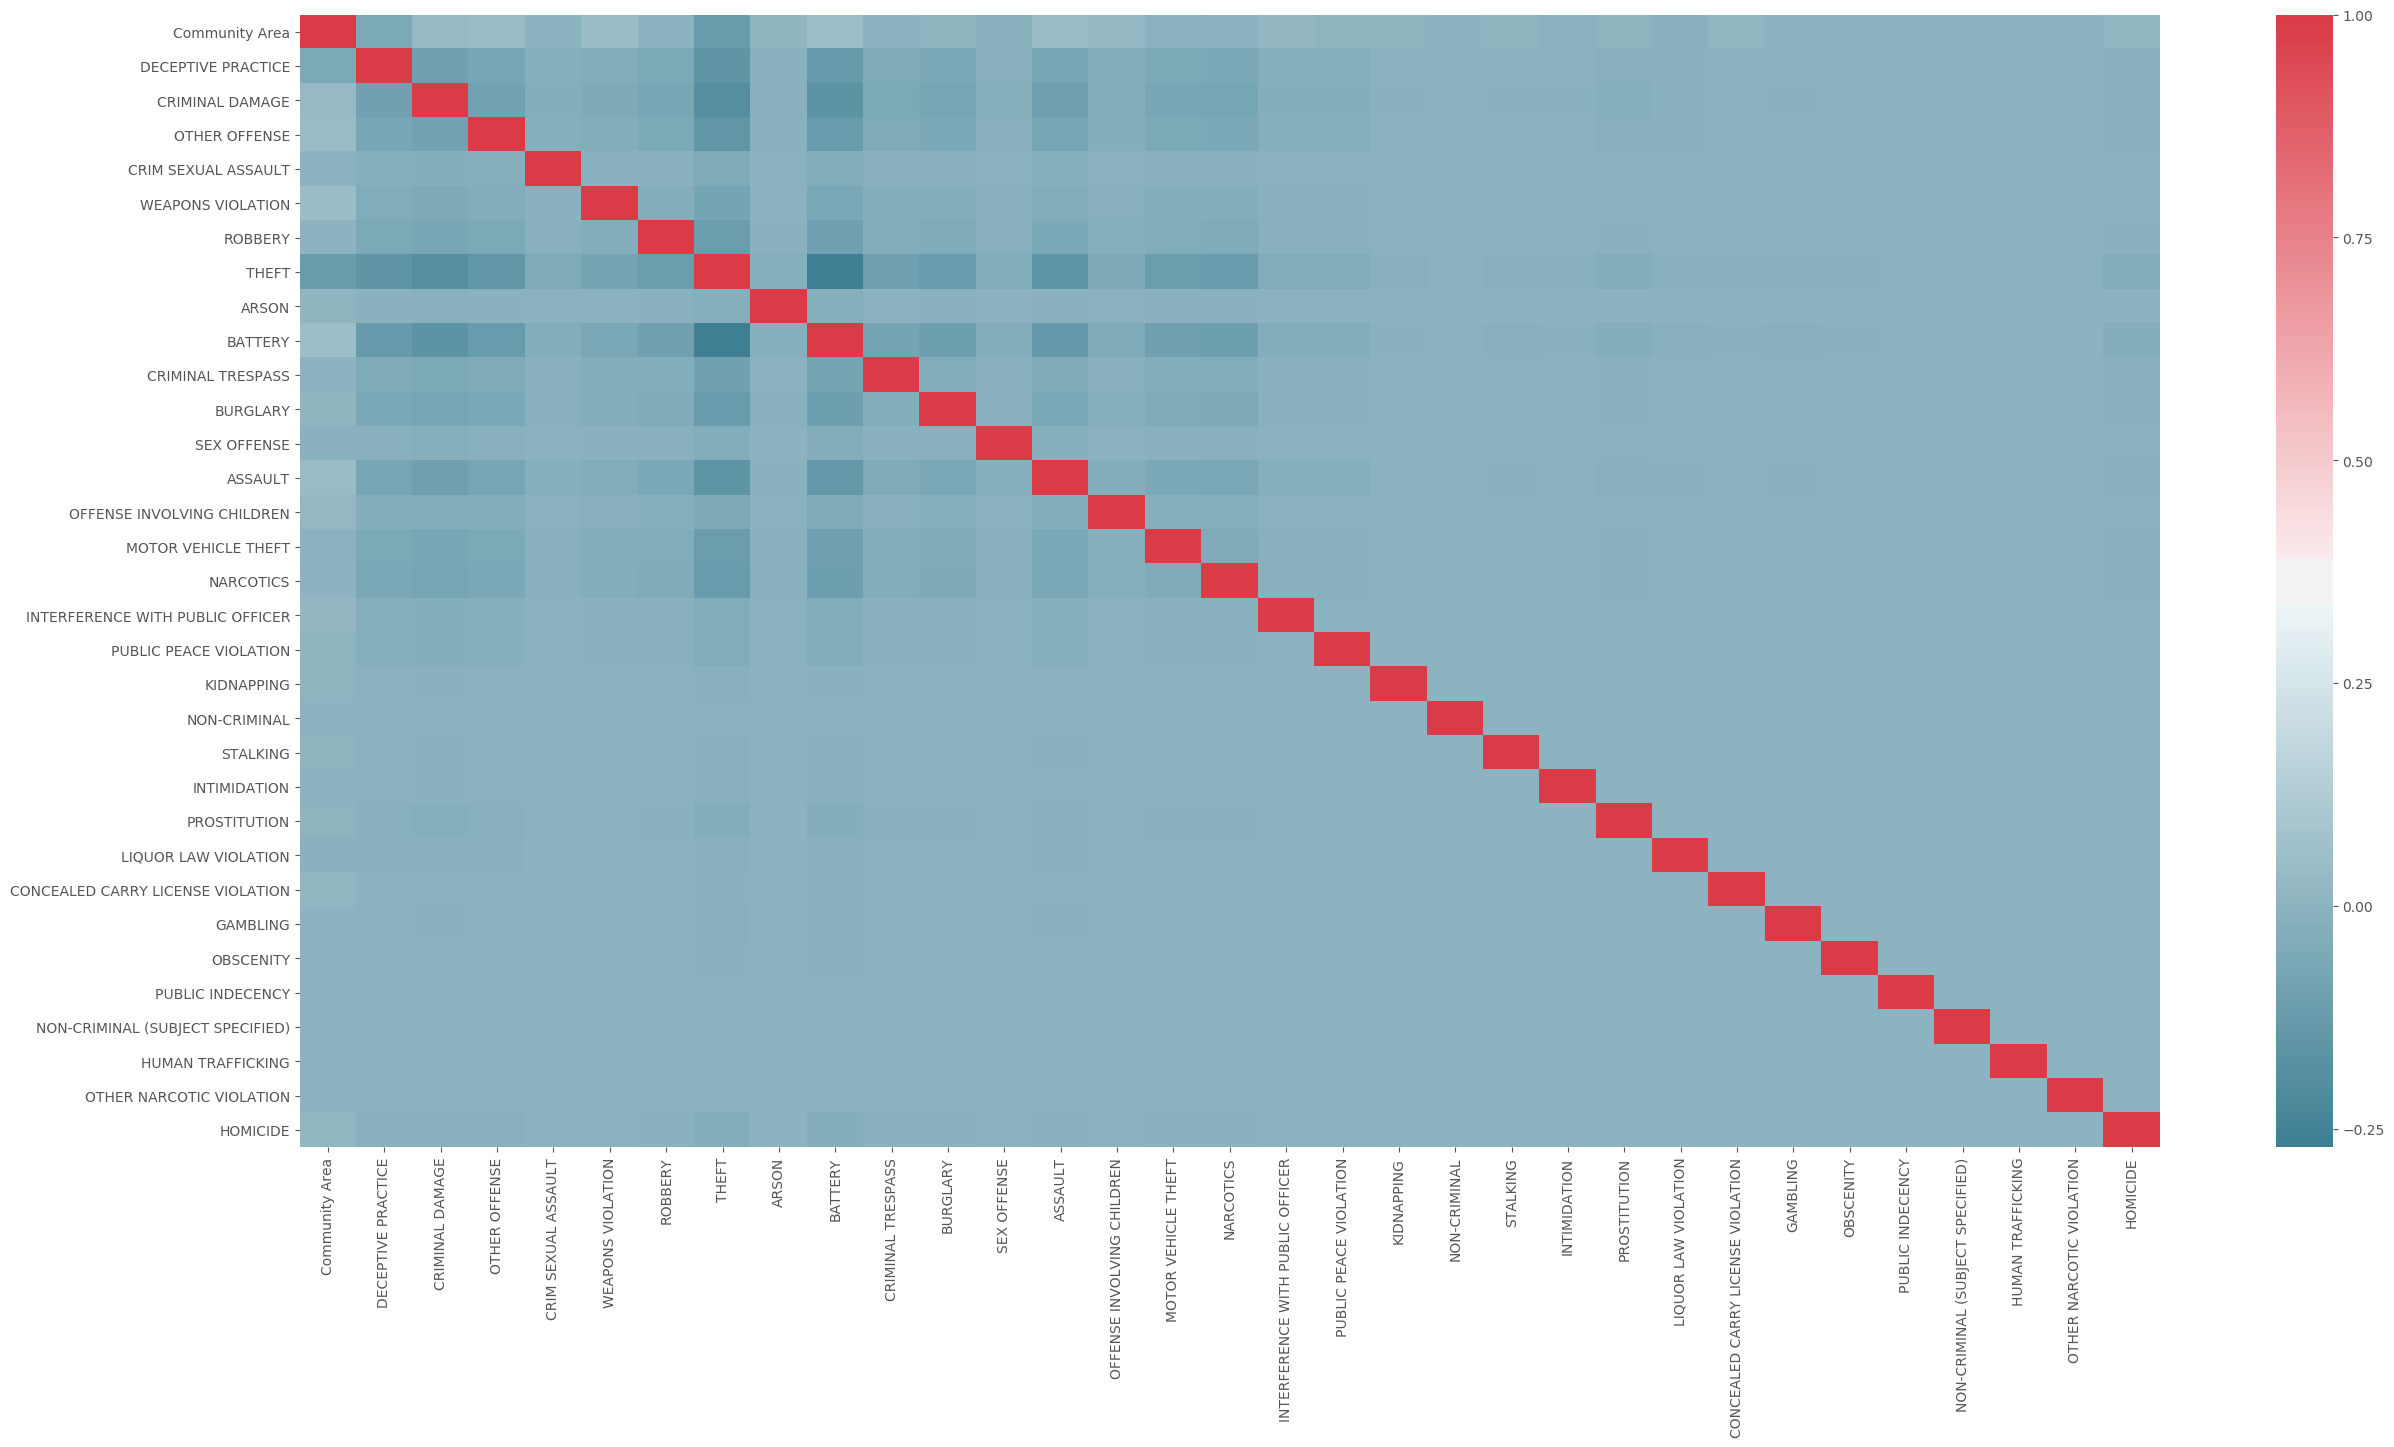

In [10]:
# Create a correlation heatmap between different crime types and community area.
corr = neighbor_df[variable_list].corr()
fig = plt.figure(figsize=(30, 15), dpi=100) 
sns.heatmap(corr, fmt="g", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

From this heatmap, it seems like community area is positively correlated with most of crime types.

Text(0, 0.5, 'Frequency')

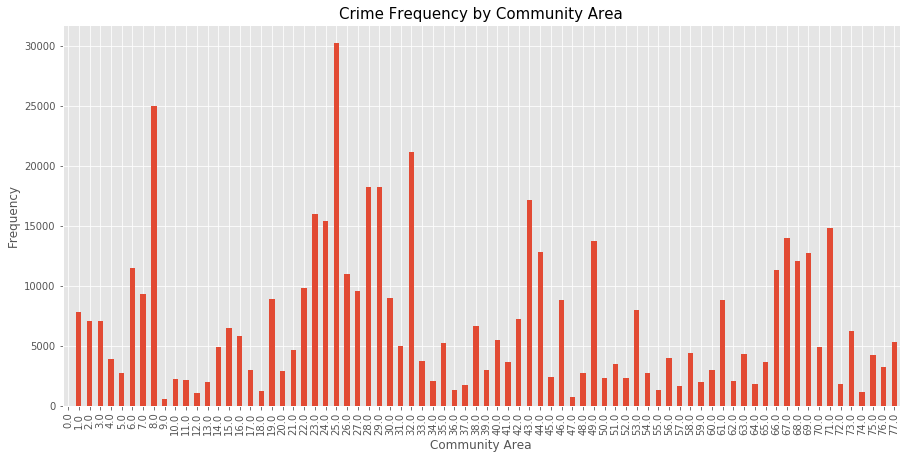

In [11]:
crime_df.groupby(["Community Area"]).size().plot(kind="bar", figsize=(15, 7))
plt.title("Crime Frequency by Community Area", fontsize=15)
plt.xlabel("Community Area")
plt.ylabel("Frequency")

Although there is no obvious pattern, some community areas definitely have more crimes than others, which supports the observation made from the heatmap.

__Data Augmentation and APIs__

All of the crime data you just analyzed have a block address and lat/long fields. The task now is to augment that data with American Community Survey data. For each crime report, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block or zipcode where the crime report came from. This could include information about demographics of the block or zipcode (race, income, family size, etc.).

Based on this augmented data, provide some descriptive statistics to describe:

1. What types of blocks have reports of “Battery”?

2. What types of blocks get “Homicide”?

3. Does that change over time in the data you collected?

4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

Using Cenpy, I will get access to ACS 5-Year Dataset.

In [12]:
# 5-Year ACS Dataset for 2017
dataset = "ACSDT5Y2017"
c.explorer.explain(dataset)

{'ACS 5-Year Detailed Tables': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population.  Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups.  Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [13]:
# Connect to the dataset
conn = c.base.Connection("ACSDT5Y2017")
conn

Connection to ACS 5-Year Detailed Tables (ID: https://api.census.gov/data/id/ACSDT5Y2017)

I will be augmenting the crime dataset with block group-level data with:

1. Median Household Income (B19013_001E)
2. Educational Attainment
3. Race, specifically race other than White (B02001_001E, B02001_002E)

In [14]:
# Querying for Dataset

variables = ["B19013_001E", "B02001_001E", "B02001_002E", "B05001_001E", "B05001_006E", "B23006_001E", "B23006_023E", "GEO_ID"]
geo_unit = "tract:*"
geo_filter = {"state": "17", "county": "031"}

acs_df = conn.query(variables, geo_unit=geo_unit, geo_filter=geo_filter)
acs_df.rename(columns={"B19013_001E":"Income", "B02001_001E":"Total_race", "B02001_002E": "White_alone", "B05001_001E": "Total_citizen", "B05001_006E": "Not_citizen", "B23006_001E": "Total_edu", "B23006_023E": "Bach_above"}, inplace=True)

# Drop median income below 0 and fix the data type

acs_df["Income"] = acs_df["Income"].astype(int)
acs_df["Total_race"] = acs_df["Total_race"].astype(int)
acs_df["White_alone"] = acs_df["White_alone"].astype(int)
acs_df["Total_citizen"] = acs_df["Total_citizen"].astype(int)
acs_df["Not_citizen"] = acs_df["Not_citizen"].astype(int)
acs_df["Total_edu"] = acs_df["Total_edu"].astype(int)
acs_df["Bach_above"] = acs_df["Bach_above"].astype(int)
acs_df = acs_df[acs_df.Income > 0]

In [15]:
acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400


__Feature Engineering__

In [16]:
# Create features using the dataset
acs_df["Race_other"] = (acs_df["Total_race"] - acs_df["White_alone"])/acs_df["Total_race"]
acs_df["Citizen"] = (acs_df["Total_citizen"] - acs_df["Not_citizen"])/acs_df["Total_citizen"]
acs_df["Low_edu"] = (acs_df["Total_edu"] - acs_df["Bach_above"])/acs_df["Total_edu"]

acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract,Race_other,Citizen,Low_edu
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000,0.091861,0.977260,0.647235
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100,0.316250,0.910000,0.847668
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500,0.560334,0.664449,0.970852
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100,0.456003,0.680104,0.963100
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400,0.389933,0.656762,0.947177


Since the Chicago Crime Dataset is based on blocks whereas the ACS dataset is based on block group, I need to spatial merge two datasets using the available spatial information.

In [17]:
conn.set_mapservice("tigerWMS_ACS2017")
acs_geodata = conn.mapservice.query(layer=8, where='STATE = 17')
acs_geodata = acs_geodata[["TRACT", "geometry"]]
acs_geodata.rename(columns={"TRACT": "tract"}, inplace=True)

In [18]:
acs_geodata.head()

,tract,geometry
0,002000,POLYGON ((-9904428.386399999 4847994.095700003...
1,807700,POLYGON ((-9770208.138699999 5164415.615199998...
2,807900,"POLYGON ((-9769643.860200001 5161260.4639, -97..."
3,809000,POLYGON ((-9765776.843699999 5169287.108499996...
4,870100,"POLYGON ((-10106515.007 4983976.344999999, -10..."


In [19]:
# Merge acs_df and acs_geodata
merged_acs_df = pd.merge(acs_df, acs_geodata, on=["tract"])

In [20]:
merged_acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract,Race_other,Citizen,Low_edu,geometry
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000,0.091861,0.977260,0.647235,POLYGON ((-9774021.387800001 5129863.688600004...
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100,0.316250,0.910000,0.847668,"POLYGON ((-9767444.9663 5128520.757799998, -97..."
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500,0.560334,0.664449,0.970852,"POLYGON ((-9762051.4256 5131215.020900004, -97..."
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100,0.456003,0.680104,0.963100,"POLYGON ((-9758278.3628 5132361.9366, -9758251..."
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400,0.389933,0.656762,0.947177,"POLYGON ((-9759901.5123 5132338.190499999, -97..."


However, because the spatial data for this merged dataset is in a different format as the Chicago Crime Dataset, I must first convert it before I can spatial join two datasets.

In [21]:
merged_acs_gdf = gpd.GeoDataFrame(merged_acs_df, geometry="geometry")
merged_acs_gdf.crs = {"init":"epsg:3395"}
merged_acs_gdf = merged_acs_gdf.to_crs({"init":"epsg:4326"})

In [22]:
# Spatial join Chicago Crime Dataset and ACS Dataset
crime_bg_df = gpd.sjoin(crime_gdf, merged_acs_gdf, op="within")
crime_bg_df = crime_bg_df.reset_index()
crime_bg_df = crime_bg_df[["Date", "Primary Type", "tract", "Year", "Income", "Race_other", "Citizen", "Low_edu"]]
crime_bg_df = crime_bg_df.dropna()
crime_bg_df["Income"] = crime_bg_df["Income"].astype(int)
crime_bg_df["Year"] = crime_bg_df["Year"].astype(int)
crime_bg_df["tract"] = crime_bg_df["tract"].astype(int)

In [23]:
crime_bg_df.head()

,Date,Primary Type,tract,Year,Income,Race_other,Citizen,Low_edu
0,09/21/2017 12:15:00 AM,DECEPTIVE PRACTICE,580501,2017,39087,0.499283,0.675067,0.90847
1,01/10/2017 08:00:00 PM,INTIMIDATION,580501,2017,39087,0.499283,0.675067,0.90847
2,01/13/2017 11:00:00 AM,OTHER OFFENSE,580501,2017,39087,0.499283,0.675067,0.90847
3,01/17/2017 06:00:00 PM,BURGLARY,580501,2017,39087,0.499283,0.675067,0.90847
4,02/14/2017 12:30:00 PM,CRIMINAL DAMAGE,580501,2017,39087,0.499283,0.675067,0.90847


In [24]:
# Change the data type of "Date" for analysis
crime_bg_df["Date"] = crime_bg_df["Date"].astype("datetime64[ns]")

1. What types of blocks have reports of “Battery”?
2. What types of blocks get “Homicide”?

In [25]:
crime_bg_df.describe()

,tract,Year,Income,Race_other,Citizen,Low_edu
count,523840.000000,523840.000000,523840.000000,523840.000000,523840.000000,523840.000000
mean,764297.994563,2017.498641,50772.763651,0.597621,0.950485,0.769296
std,105382.213674,0.499999,19816.979997,0.310104,0.062311,0.128320
min,490600.000000,2017.000000,12660.000000,0.005914,0.609947,0.133203
25%,730201.000000,2017.000000,36307.000000,0.319461,0.930352,0.700896
50%,823302.000000,2017.000000,48391.000000,0.583236,0.972450,0.801333
75%,827901.000000,2018.000000,61736.000000,0.907900,0.990907,0.855571
max,842800.000000,2018.000000,202727.000000,1.000000,1.000000,0.986092


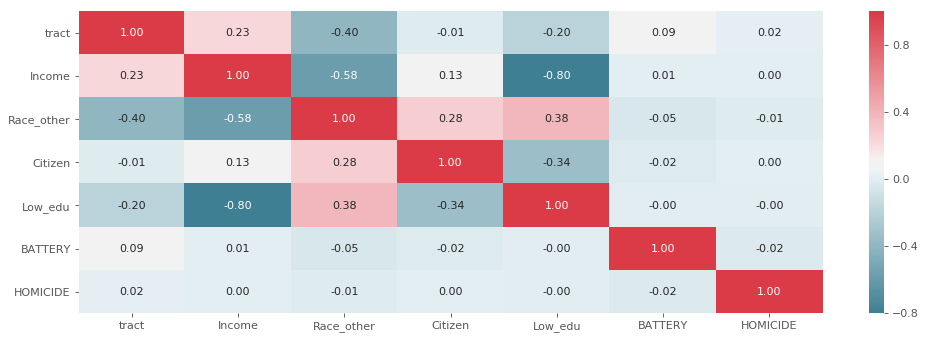

In [26]:
## Create a correlation heatmap of various demographic features and "Battery"/"Homicide"
corr_crime_df = pd.concat([crime_bg_df, pd.get_dummies(crime_bg_df["Primary Type"])], axis=1)
corr2 = corr_crime_df[["tract", "Income", "Race_other", "Citizen", "Low_edu", "BATTERY", "HOMICIDE"]].corr()
fig = plt.figure(figsize=(15, 5), dpi=80) 
sns.heatmap(corr2, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

From what we can see, there is no obviously defining features of tracts that have reports of battery or homicide with the demographic features that I selected.
- Battery: It seems to be weakly but positively correlating with median income and negatively correlating with the proportion of other races and citizens.
- Homicide: It is weakly and negatively correlated with the proprotion of other races.

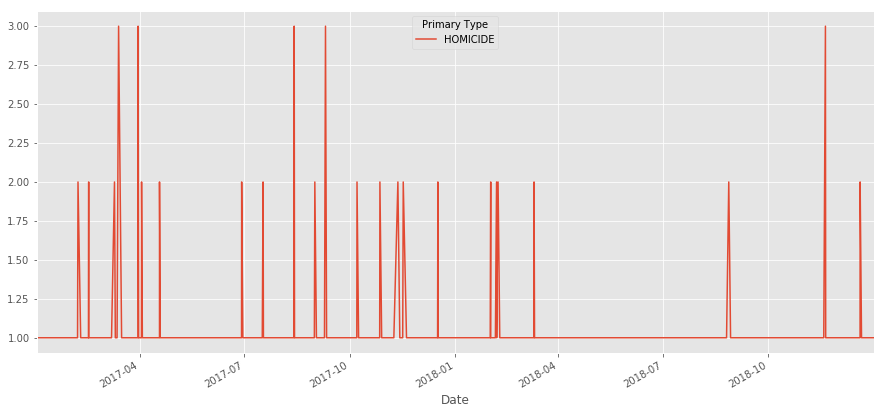

In [27]:
# Look at homicide over time
hom_df = crime_bg_df[(crime_bg_df["Primary Type"] == "HOMICIDE")]
hom_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize=(15,7))

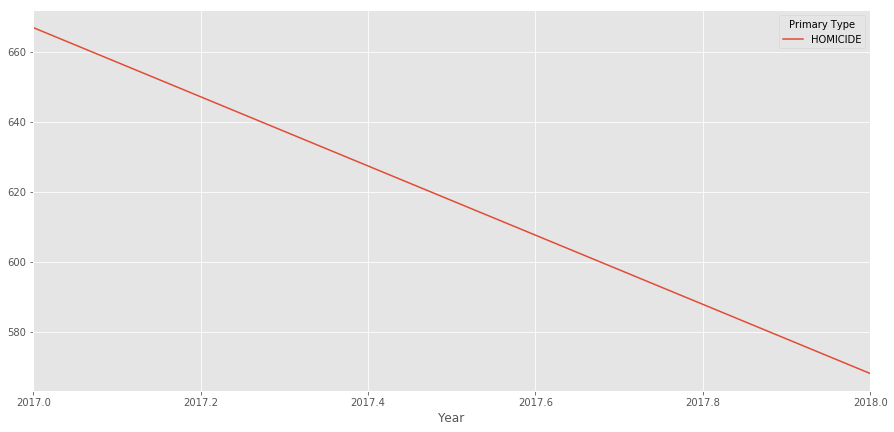

In [28]:
hom_df.groupby(['Year', 'Primary Type']).size().unstack().plot(figsize=(15,7))

According to these graphs, "Homicide" seemed to have decreased over 2017 - 2018.

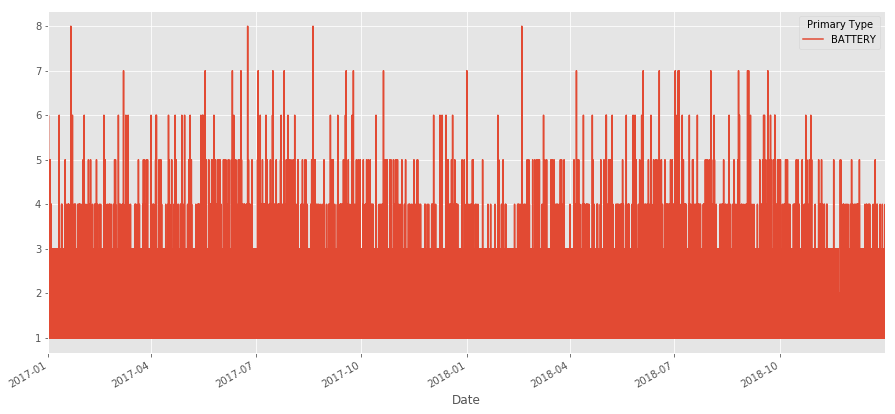

In [29]:
# Look at battery over time
bat_df = crime_bg_df[(crime_bg_df["Primary Type"] == "BATTERY")]
bat_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize=(15,7))

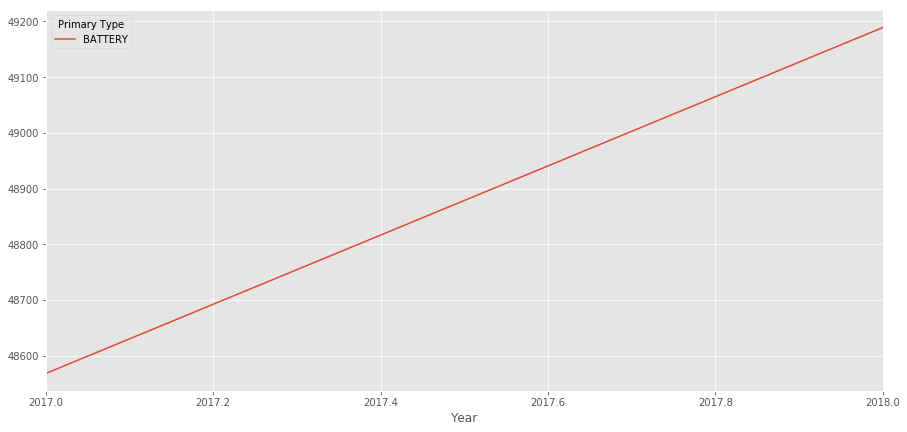

In [30]:
bat_df.groupby(['Year', 'Primary Type']).size().unstack().plot(figsize=(15,7))

We can see that the number of batteries over 2017 - 2018 has increased overall.

In [31]:
# create weekday column
bat_hom_df['weekday'] = bat_hom_df['Date'].dt.dayofweek

# visualize service requests by weekday
bat_hom_df.groupby(['weekday', 'Primary Type']).size().unstack().plot(figsize=(10,5))

NameError: name 'bat_hom_df' is not defined

In [ ]:
hom_df = pd.DataFrame(crime_bg_df[crime_bg_df["Primary Type"] == "HOMICIDE"].groupby(["GEO_ID"]).mean()["Income"])
hom_df["Homicide Count"] = crime_bg_df[crime_bg_df["Primary Type"] == "HOMICIDE"].groupby(["GEO_ID"]).size()
hom_df.plot(x="Income", y="Homicide Count", style='o', figsize=(15,7), logx=True)

In [ ]:
hom_df = pd.DataFrame(crime_bg_df[crime_bg_df["Primary Type"] == "DECEPTIVE PRACTICE"].groupby(["GEO_ID"]).mean()["Income"])
hom_df["Homicide Count"] = crime_bg_df[crime_bg_df["Primary Type"] == "DECEPTIVE PRACTICE"].groupby(["GEO_ID"]).size()
hom_df.plot(x="Income", y="Homicide Count", style='o', figsize=(15,7), ylim=(0, 100))

In [ ]:
crime_bg_df.groupby(['Primary Type']).mean()['Income'].plot(kind='bar', figsize=(7, 7), rot=0)

In [ ]:
corr_vars = list(crime_bg_df.columns)
corr_vars.extend(['HOMICIDE', 'BATTERY', 'DECEPTIVE PRACTICE'])

In [ ]:
crime_bg_df_t = pd.concat([crime_bg_df, pd.get_dummies(crime_bg_df['Primary Type'])], axis=1)
corr = crime_bg_df_t[['GEO_ID', 'HOMICIDE', 'BATTERY', 'DECEPTIVE PRACTICE', 'SEX OFFENSE']].corr()
fig = plt.figure(figsize=(12, 3), dpi=80) 
sns.heatmap(corr, annot=True, fmt='g', cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [ ]:
crime_bg_df.head()

In [ ]:
crime_bg_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize = (15,7))

In [ ]:
crime_bg_df.groupby(['GEO_ID', 'Primary Type']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

In [ ]:
hom_df = crime_bg_df[(crime_bg_df['Primary Type'] == "HOMICIDE") | (crime_bg_df['Primary Type'] == "BATTERY")]

In [ ]:
# create weekday column
hom_df['weekday'] = hom_df['Date'].dt.dayofweek

# visualize service requests by weekday
hom_df.groupby(['weekday', 'Primary Type']).size().unstack().plot(figsize=(10,5))

In [ ]:
hom_df.groupby(['Date', 'Primary Type']).size().unstack().plot(figsize=(15,7))